# **Project Pipeline**

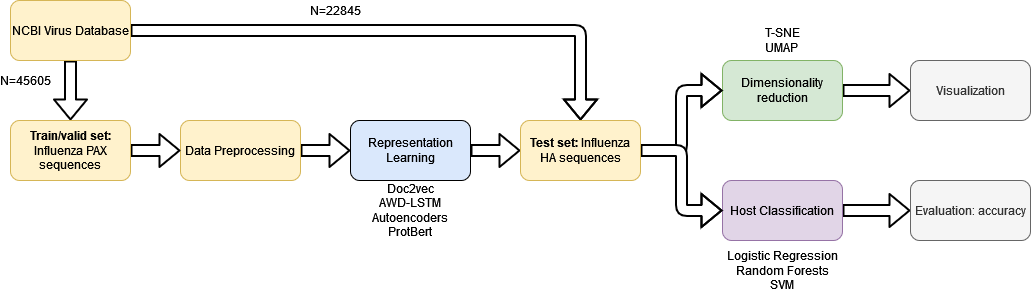

In this notebook, we use CNN autoencoders and Vartional autoencoders to extract viral protein embeddings, that we later visualize them by applying dimensionalilty reduction, or use them to determine the predicted host for the influenza A virus

In [ ]:
!pip install pytorch_lightning > /dev/null
!pip install umap-learn > /dev/null
!pip install -q wandb

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
import random
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

from sklearn.manifold import TSNE
import umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = Path('/content/drive/MyDrive/PFE/')

NameError: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pl.utilities.seed.seed_everything(42)

Global seed set to 42


42

We ilustrate the inference process of CNN autoencoders and Vartional autoencoders as following :



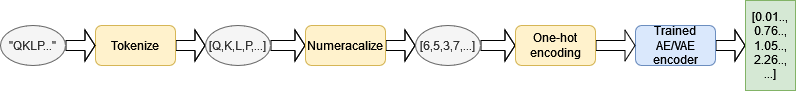

# **Preprocessing Influenza A sequences**

In [ ]:

df_test = pd.read_csv(path/'data/prot_sequences_influenza_ha_3_species.csv')
df = pd.read_csv(path/'data/prot_sequences_pax_3.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# df['sequences'] = df['sequences'].map(lambda x: ' '.join(x))

In [ ]:
df['sequences'] = df['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x))

df_test['sequences'] = df_test['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x))

In [ ]:
def yield_tokens(sequences):
  for seq in sequences:
    yield list(seq)

In [ ]:
vocab = build_vocab_from_iterator(yield_tokens(df['sequences']), specials=['<pad>', '<bos>', '<eos>'])

In [ ]:
len(vocab)

25

In [ ]:
def data_process(sequences):
  data = []
  for seq in sequences:
    aa_tensor = torch.tensor([vocab[token] for token in list(seq)], 
                             dtype=torch.long)
    data.append(aa_tensor)
  
  return data

In [ ]:
split_point = int(len(df)*0.9)
train_data = data_process(df.loc[:split_point,'sequences'])
valid_data = data_process(df.loc[split_point:,'sequences'])
test_data = data_process(df_test['sequences'])

In [ ]:
class ProtDataModule(pl.LightningDataModule):
  def __init__(self, train_data, valid_data, test_data, vocab, batch_size = 128, max_len=400):
    super().__init__()

    self.pad_idx = vocab['<pad>']
    self.eos_idx = vocab['<eos>']
    self.bos_idx = vocab['<bos>']
    self.max_len = max_len + 2

    self.train_data = train_data 
    self.valid_data = valid_data
    self.test_data = test_data
    self.batch_size = batch_size


  def generate_batch(self, data_batch):
    aa_batch = []
    for item in data_batch:
      x = torch.cat([torch.tensor([self.bos_idx]), item, torch.tensor([self.eos_idx])], dim=0)
      x_padded = torch.full((self.max_len,), self.pad_idx, dtype=torch.long)

      x_padded[:len(x)] = x
      aa_batch.append(x_padded)

    aa_batch_tensor = torch.stack(aa_batch, 0)
    return aa_batch_tensor


  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=self.generate_batch)
  
  def val_dataloader(self):
    return DataLoader(self.valid_data, batch_size=self.batch_size, collate_fn=self.generate_batch)

  def predict_dataloader(self):
    return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.generate_batch)

In [ ]:
prot_datamodule = ProtDataModule(train_data, valid_data, test_data, vocab)

### Test lstm embeddings

In [ ]:
vocab = ['E','K','L','I','A','R','T','S','F','D','V','N','P','M','G','Y','H','C','Q','W','X','J']

aa_embeds = np.load(path/"embeddings/doc2vec_embeds.npy")

aa_embeds[vocab.index('A')]

array([ 1.1765339 , -0.9376409 , -0.22433779,  0.59512126, -0.30562297,
       -0.06619592, -0.1601195 ,  0.49466982, -0.39493886,  0.2728861 ,
       -0.45156768,  1.1044685 ,  0.3401548 , -0.6410264 ,  0.21897799,
        1.2271911 ,  0.23949747, -1.3013135 ,  0.38062027,  0.5974363 ,
        0.22260931, -0.5751234 ,  0.10153205,  0.50922126, -0.13805646,
        0.39445928, -0.68286276, -0.46712077, -0.24824898, -0.39369354,
       -0.10025732, -0.22515178,  0.31753403, -1.0412912 , -0.4999651 ,
       -0.26342076,  1.8926362 , -0.18847696, -0.24728592, -0.79016507,
        0.72979075,  0.29601687, -0.08153763, -0.7111963 , -0.2693478 ,
       -0.42220572, -0.88438547, -0.6932772 , -0.4486597 , -0.19879119],
      dtype=float32)

In [ ]:
embs = torch.rand((25, 25), dtype=torch.float32, device='cuda')

# **CNN Autoencoders**

In [ ]:
class CNN_AutoEncoder(pl.LightningModule):

  def __init__(self, criterion, k_size=3,stride=1,pad=1):
      super().__init__()
      
      self.criterion = criterion
      ## encoder ##       
      self.conv1 = nn.Sequential(
          nn.Conv1d(25, 15,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(15))

      self.conv2 = nn.Sequential(
          nn.Conv1d(15, 5,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(5))
      
      self.conv3 = nn.Sequential(
          nn.Conv1d(5,1,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(1))
      
      self.fc_encode = nn.Sequential(nn.Linear(1*402, 128))
      
      self.fc_decode = nn.Sequential(nn.Linear(128, 1*402))
      

      ## decoder ##
      self.deconv3 = nn.Sequential(
          nn.ConvTranspose1d(1, 5,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(5))
      
      self.deconv2 = nn.Sequential(
          nn.ConvTranspose1d(5, 15,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(15))

      self.deconv1 = nn.Sequential(
          nn.ConvTranspose1d(15, 25,  k_size, stride, padding=pad))
  

  def encoder(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    # print(out.shape)
    out = out.view(-1, 1 * 402)
    out = self.fc_encode(out)
    return out

  def decoder(self, out):
    #out = self.fc2_decode(out)
    
    out = self.fc_decode(out)
    out = out.view(-1, 1,402) # re-shape array but not batches
    out = self.deconv3(out)
    out = self.deconv2(out)
    out = self.deconv1(out)

    return out


  def to_one_hot(self, X):
    """Embedding seq integers to one-hot form. """
    num_classes=25
    if torch.cuda.is_available():
      # to_one_hot = embs
      to_one_hot = torch.eye(num_classes,dtype=torch.float32,device='cuda')
    else:
      # to_one_hot = embs
      to_one_hot = torch.eye(num_classes,dtype=torch.float32)    
    _x = to_one_hot[X]
    return _x
      

  def from_one_hot(self, one_hot):
      """decode seq from one-hot form."""
      X = torch.argmax(one_hot,dim=1) 
      if  torch.cuda.is_available():
        X.cuda()
      return X


  def forward(self, x):
    x = self.to_one_hot(x)
    x = torch.transpose(x,1,2) 

    embedding = self.encoder(x)

    batch_size = x.shape[0]
    # print(x.shape)
    embedding = embedding.view(batch_size,-1)
    return embedding

  def training_step(self, batch, batch_idx):
    x = self.to_one_hot(batch)

    x = torch.transpose(x,1,2) 
    latent_vec = self.encoder(x)

    out = self.decoder(latent_vec)

    # x_hat = self.from_one_hot(out)

    loss = self.criterion(x, out)

    self.log('train_loss',loss,on_step = True,on_epoch = True,prog_bar = True)

    return loss

  def validation_step(self, batch, batch_idx):
    x = self.to_one_hot(batch)

    x = torch.transpose(x,1,2) 
    # print(x.dtype)

    # print(x.shape)

    latent_vec = self.encoder(x)

    out = self.decoder(latent_vec)

    # print(out.shape)

    # x_hat = self.from_one_hot(out)
    # print(x_hat.shape)
    loss = self.criterion(x, out)   

    self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

    return loss


  def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)


In [ ]:
wandb_logger = pl_loggers.WandbLogger()

In [ ]:
criterion = nn.MSELoss()



# tb_logger = pl_loggers.TensorBoardLogger("logs/")
model = CNN_AutoEncoder(criterion = criterion)
trainer = pl.Trainer(max_epochs=50, gpus=1, logger=wandb_logger, precision=16)   

start = time.time()       
trainer.fit(model, datamodule=prot_datamodule)
print(time.time() - start)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: issam (use `wandb login --relogin` to force relogin)



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | conv1     | Sequential | 1.2 K 
2 | conv2     | Sequential | 240   
3 | conv3     | Sequential | 18    
4 | fc_encode | Sequential | 51.6 K
5 | fc_decode | Sequential | 51.9 K
6 | deconv3   | Sequential | 30    
7 | deconv2   | Sequential | 270   
8 | deconv1   | Sequential | 1.2 K 
-----------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.425     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

563.1005268096924


In [ ]:
embeds = trainer.predict(model=model, datamodule=prot_datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 321it [00:00, ?it/s]

In [ ]:
embeds[0].shape

torch.Size([128, 128])

In [ ]:
h = embeds[0]
# h = h.squeeze(0)
for i in range(1, len(embeds)):
  x = embeds[i]
  h = torch.cat((h, x))

h.shape

torch.Size([22845, 128])

In [ ]:
embeds_2d = TSNE(n_components=2, n_iter=3000, random_state=42).fit_transform(h.cpu())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


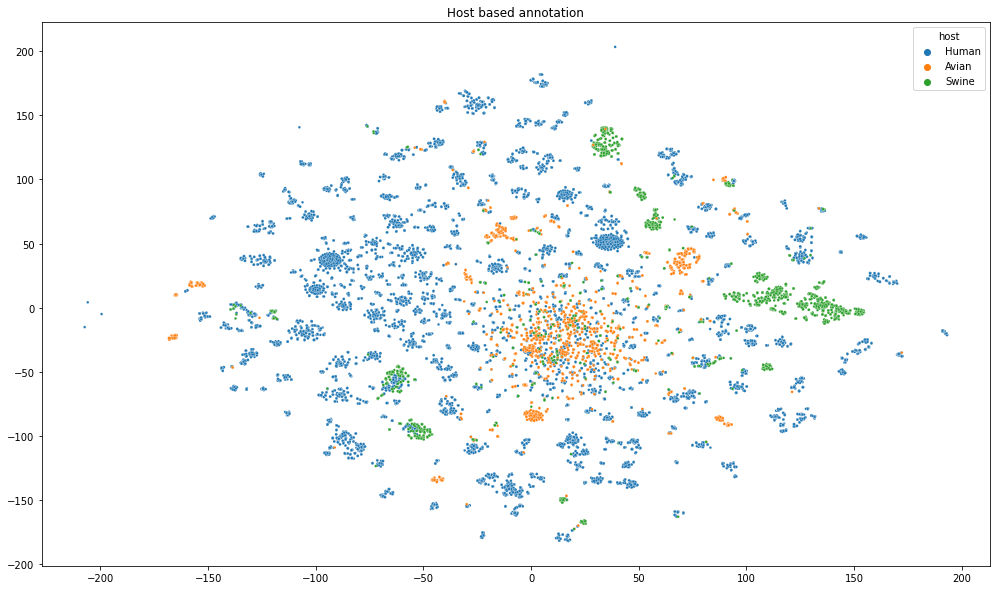

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds_2d[:,0], embeds_2d[:, 1], hue=df_test['host'], s=7)
plt.savefig(path/'plots/results/cnn_ae_tsne')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


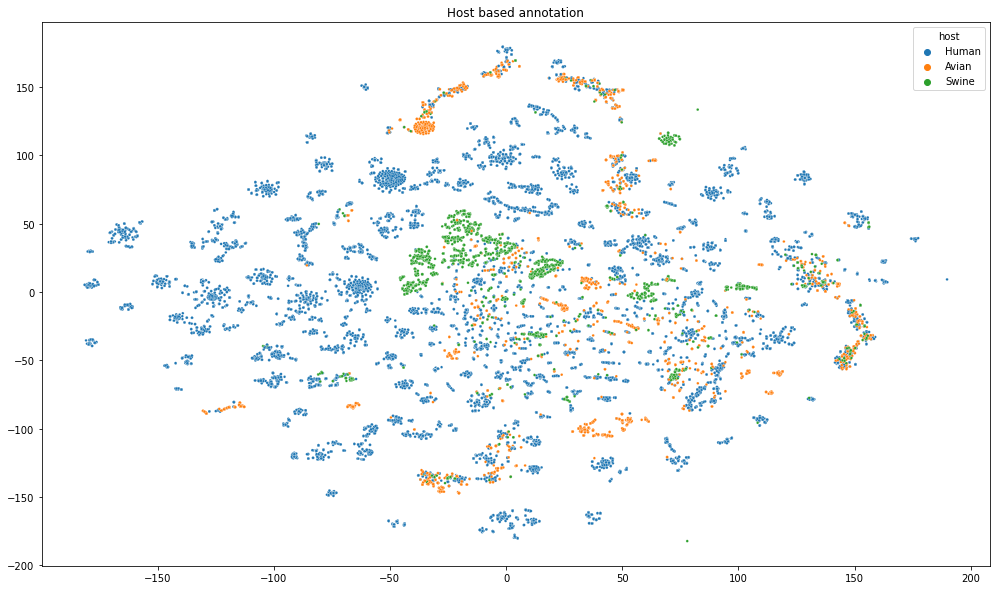

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds_2d[:,0], embeds_2d[:, 1], hue=df_test['host'], s=7)

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

In [ ]:
umap_embeds_2d = reducer.fit_transform(h.cpu())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


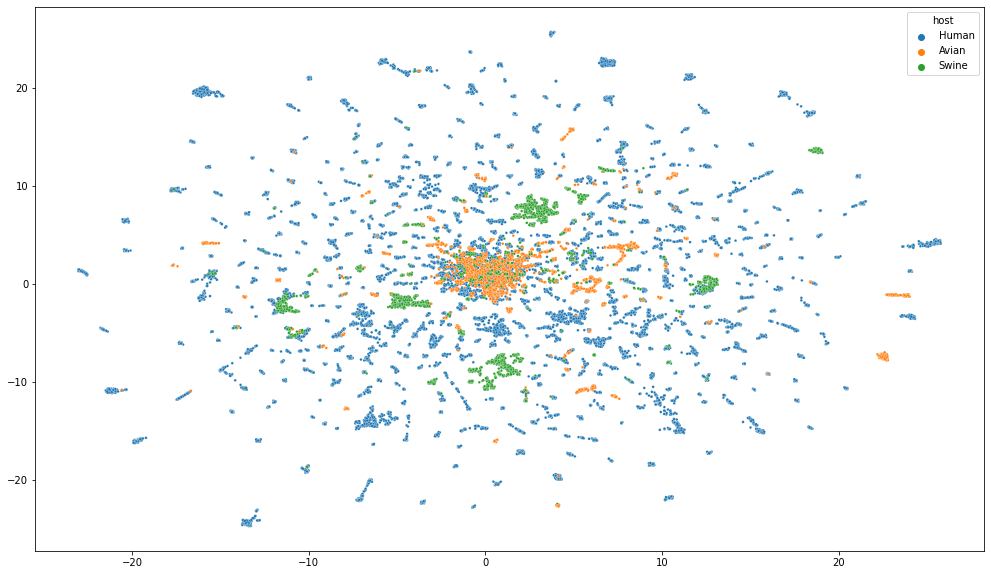

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df_test['host'], s=7)
plt.savefig(path/'plots/results/cnn_ae_umap')

# **Variational CNN Autoencoders**

In [ ]:
class CNN_VAE(pl.LightningModule):

  def __init__(self, criterion, k_size=3,stride=1,pad=1, latent_dim=128, kl_coeff=0.1):
      super().__init__()
      
      self.criterion = criterion
      self.latent_dim = latent_dim
      self.kl_coeff = kl_coeff
      ## encoder ##       
      self.conv1 = nn.Sequential(
          nn.Conv1d(25, 15,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(15))

      self.conv2 = nn.Sequential(
          nn.Conv1d(15, 5,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(5))
      
      self.conv3 = nn.Sequential(
          nn.Conv1d(5,1,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(1))
      
      self.fc_mu = nn.Linear(1*402, latent_dim)
      self.fc_var = nn.Linear(1*402, latent_dim)
      self.latent2hid = nn.Linear(latent_dim, 1*402)
      

      ## decoder ##
      self.deconv3 = nn.Sequential(
          nn.ConvTranspose1d(1, 5,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(5))
      
      self.deconv2 = nn.Sequential(
          nn.ConvTranspose1d(5, 15,  k_size, stride, padding=pad),
          nn.ReLU(),
          nn.BatchNorm1d(15))

      self.deconv1 = nn.Sequential(
          nn.ConvTranspose1d(15, 25,  k_size, stride, padding=pad))
  

  def encoder(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = out.view(-1, 1 * 402)
    return out


  def decoder(self, out):
    out = out.view(-1, 1, 402) # re-shape array but not batches
    out = self.deconv3(out)
    out = self.deconv2(out)
    out = self.deconv1(out)
    return out

  
  def sample(self, mu, log_var):
    std = torch.exp(log_var / 2)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    return p, q, z

  
  def _run_step(self, x):
    x = self.encoder(x)
    mu = self.fc_mu(x)
    log_var = self.fc_var(x)
    p, q, z = self.sample(mu, log_var)
    out = self.latent2hid(z)
    return z, self.decoder(out), p, q

  
  def step(self, batch, batch_idx):
    x = self.to_one_hot(batch)
    x = torch.transpose(x,1,2)
    z, out, p, q = self._run_step(x)

    # x_hat = self.from_one_hot(out)
    recon_loss = self.criterion(x, out)

    log_qz = q.log_prob(z)
    log_pz = p.log_prob(z)

    kl = -log_pz * (log_qz - log_pz)
    kl = kl.mean()
    kl *= self.kl_coeff

    loss = kl + recon_loss

    logs = {
        "recon_loss": recon_loss,
        "kl": kl,
        "loss": loss,
    }
    return loss, logs


  def to_one_hot(self, X):
    """Embedding seq integers to one-hot form. """
    num_classes=25
    if torch.cuda.is_available():
      to_one_hot = torch.eye(num_classes,dtype=torch.float32,device='cuda')
    else:
      to_one_hot = torch.eye(num_classes,dtype=torch.float32)    
    _x = to_one_hot[X]
    return _x
      

  def from_one_hot(self, one_hot):
    """decode seq from one-hot form."""
    X = torch.argmax(one_hot,dim=1) 
    if  torch.cuda.is_available():
      X.cuda()
    return X


  def forward(self, x):
    x = self.to_one_hot(x)
    x = torch.transpose(x,1,2) 
    out = self.encoder(x)
    embedding = self.fc_mu(out)
    batch_size = x.shape[0] 
    embedding = embedding.view(batch_size,-1)
    return embedding


  def training_step(self, batch, batch_idx):
    loss, logs = self.step(batch, batch_idx)
    self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
    return loss


  def validation_step(self, batch, batch_idx):
      loss, logs = self.step(batch, batch_idx)
      self.log_dict({f"val_{k}": v for k, v in logs.items()})
      return loss


  def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)

In [ ]:
wandb_logger = pl_loggers.WandbLogger(name='issam2', project='cnn_ae')


In [ ]:
criterion = nn.MSELoss()

model = CNN_VAE(criterion = criterion)
trainer = pl.Trainer(max_epochs=50, gpus=1, logger=wandb_logger, precision=16)        

start = time.time()       
trainer.fit(model, datamodule=prot_datamodule)
print(time.time() - start)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: issam (use `wandb login --relogin` to force relogin)



  | Name       | Type       | Params
------------------------------------------
0 | criterion  | MSELoss    | 0     
1 | conv1      | Sequential | 1.2 K 
2 | conv2      | Sequential | 240   
3 | conv3      | Sequential | 18    
4 | fc_mu      | Linear     | 51.6 K
5 | fc_var     | Linear     | 51.6 K
6 | latent2hid | Linear     | 51.9 K
7 | deconv3    | Sequential | 30    
8 | deconv2    | Sequential | 270   
9 | deconv1    | Sequential | 1.2 K 
------------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.632     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

758.1351721286774


In [ ]:
embeds = trainer.predict(model=model, datamodule=prot_datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 321it [00:00, ?it/s]

In [ ]:
h = embeds[0]
# h = h.squeeze(0)
for i in range(1, len(embeds)):
  x = embeds[i]
  h = torch.cat((h, x))

h.shape

torch.Size([22845, 128])

In [ ]:
# np.save(path/"embeddings/cnn_ae_embeds.npy", h.cpu())

# **Dimentionality Reduction**

We assessed the information captured by the embeddings extracted from the viral protein sequences using AWD-LSTM by projecting the high dimensional representations in two dimensional space (2D), using TSNE and UMAP. Toward this end, we choose to visualize the influenza A protein representations according to three major hosts (Human, Swine, Avian).

# 1- TSNE Projection

In [ ]:
embeds_2d = TSNE(n_components=2, n_iter=3000, random_state=42).fit_transform(h.cpu())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


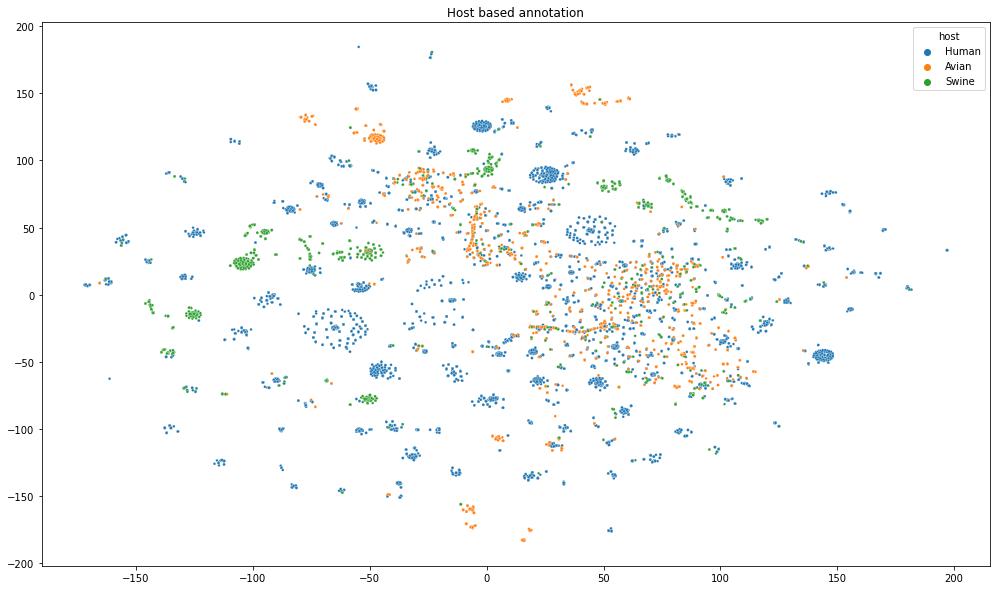

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds_2d[:,0], embeds_2d[:, 1], hue=df_test['host'], s=7)
plt.savefig(path/'plots/results/vae_tsne')

# 2- *UMAP* Projection

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

In [ ]:
umap_embeds_2d = reducer.fit_transform(h.cpu())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


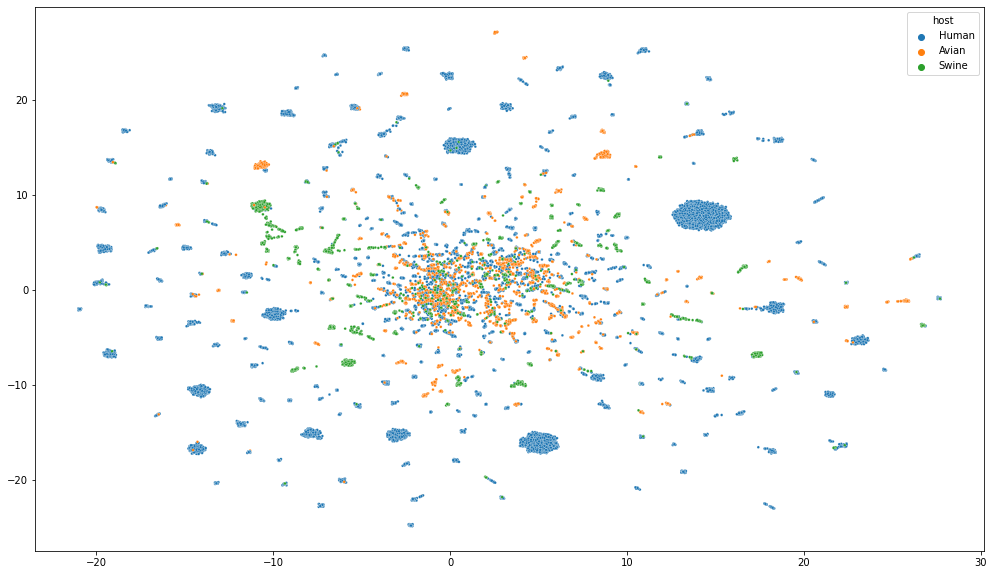

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df_test['host'], s=7)
plt.savefig(path/'plots/results/vae_umap')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


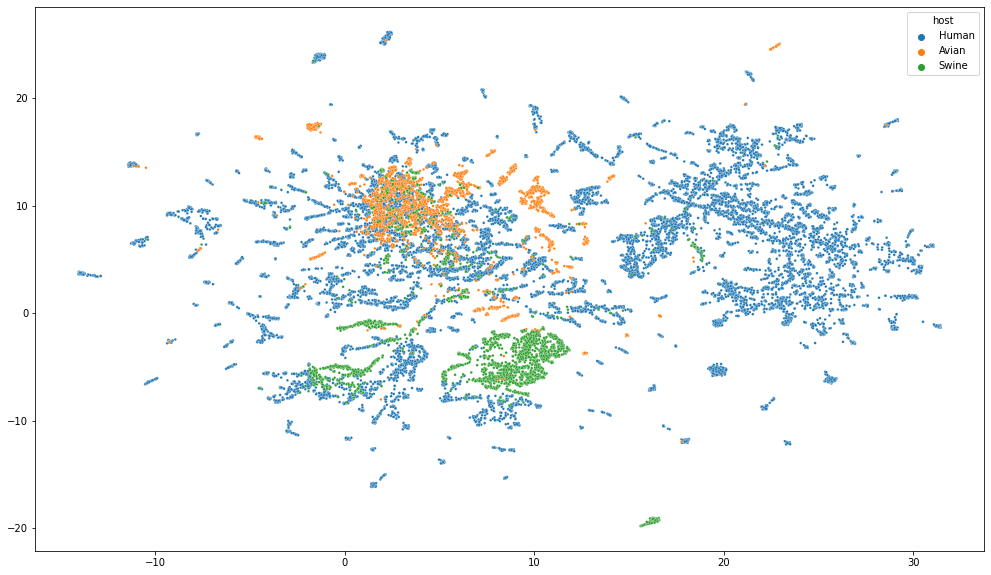

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df_test['host'], s=7)

# **Protein Host Prediction**

To compare the representations produced by each model, we build different classifiers that use these representations as input to classify the sequences into three possible hosts that are Human, Swine or Avian.

# Classifiers

 Since the data is imbalanced with most sequences coming from human hosts, we balance our data using SMOTE (Synthetic Minority Oversampling Technique), where we do oversampling of the minority classes, SMOTE does this by synthesizing the samples along the class decision boundary. 

In [ ]:
# balance data with smote
from imblearn.over_sampling import SMOTE

X, y = h.cpu(), df_test['host']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X.shape, X_res.shape

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

(torch.Size([22845, 128]), (52527, 128))

In [ ]:
len(y_res[y_res=='Human']), len(y_res[y_res=='Avian']), len(y_res[y_res=='Swine'])

(17509, 17509, 17509)

After oversampling, we split the data randomly into train and test set, we used 30% of the data for testing the model, and the rest for training.

**Logistic Regression**

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.7594390507011867

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.7573222236860806

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.9027136755246795

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(X_test, y_test)

0.7763817501110477

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.772941709868367

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.9156711710498188

**Support Vector Machine**


In [ ]:

from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
clf.score(X_test, y_test)

0.8040484802335174

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.8049617436680685

### Visualization with balancing

In [ ]:
embeds = TSNE(n_components=2, n_iter=3000).fit_transform(X_res)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


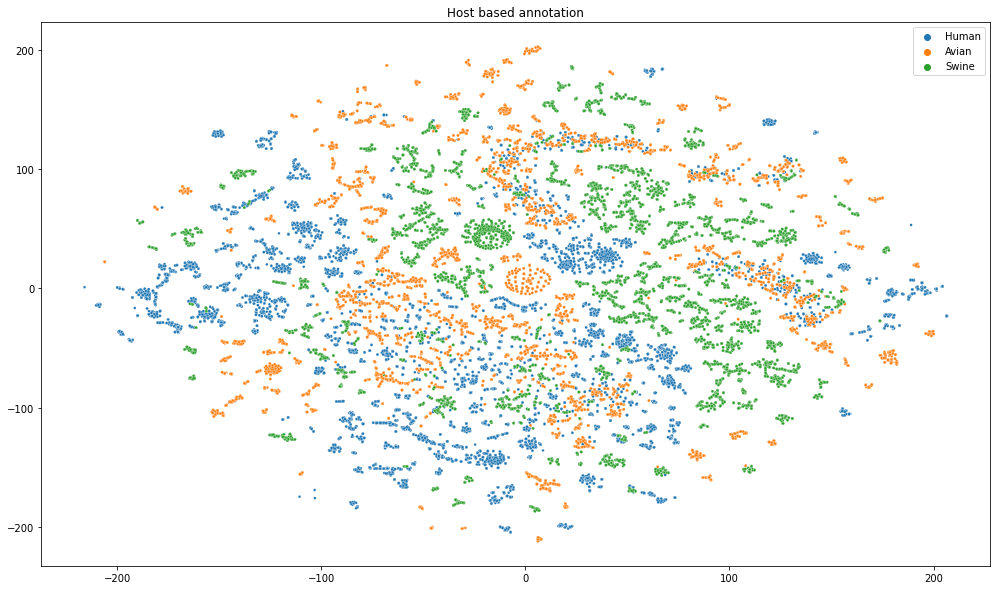

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds[:,0], embeds[:, 1], hue=y_res, s=7)

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

In [ ]:
umap_embeds_2d = reducer.fit_transform(X_res)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


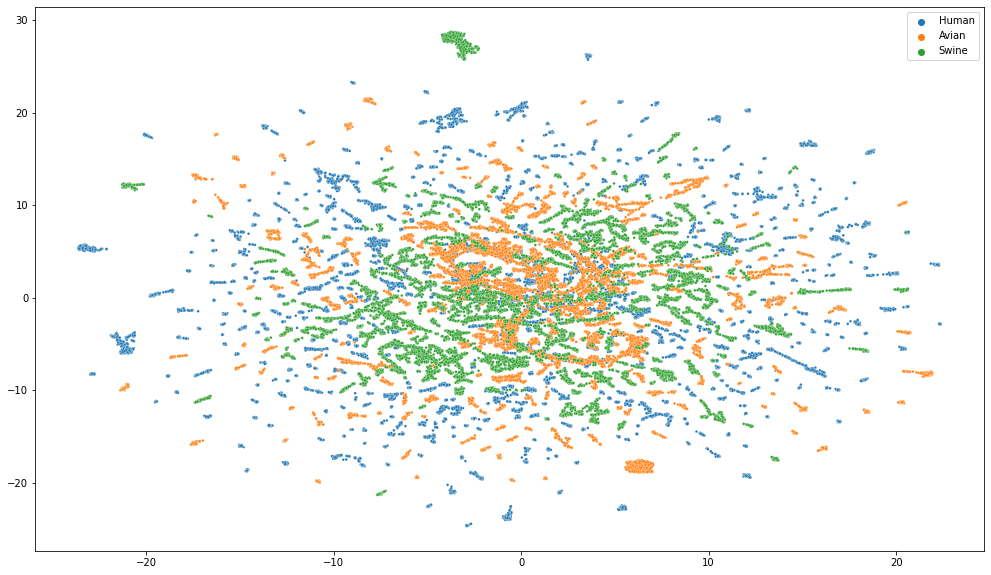

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=y_res, s=7)